In [1]:
!pip install pydantic langchain-teddynote langchain_community langchain_huggingface langchain_openai

from google.colab import output

output.clear()

In [2]:
import os

from google.colab import userdata

# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_PROJECT"] = "LangChain 실습"
# Langchain API key 입력
# os.environ["LANGCHAIN_API_KEY"] = userdata.get('langsmith_api_key')

In [3]:
import zipfile

# 데이터 처리 및 분석
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import datetime

from sklearn.metrics.pairwise import cosine_similarity

# 모델 저장
import joblib

# To ignore all warnings
import warnings
warnings.filterwarnings('ignore')



In [4]:
from langchain_community.chat_models import ChatPerplexity
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import PromptTemplate

from langchain_core.output_parsers import CommaSeparatedListOutputParser
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field

os.environ["OPENAI_API_KEY"] = userdata.get('KOTRA2_openai_api_key')


# API 사용 rate 제한 설정


In [5]:
from langchain_core.rate_limiters import InMemoryRateLimiter

rate_limiter_openai = InMemoryRateLimiter(
    requests_per_second=5,  # maximum query per day - 10000 (tier 1)
    check_every_n_seconds=0.1,  # Wake up every 100 ms to check whether allowed to make a request,
    max_bucket_size=10,  # Controls the maximum burst size.
    )

<ipython-input-5-5cc4985cb9b0>:3: LangChainBetaWarning: Introduced in 0.2.24. API subject to change.
  rate_limiter_openai = InMemoryRateLimiter(


# 사용 모델 설정

In [6]:
chat_openai = ChatOpenAI(temperature=0,  model="gpt-4o-mini", rate_limiter=rate_limiter_openai)

# One-Shot 방법

In [ ]:
category_prompt_hscode = PromptTemplate.from_template(
    """You are given data input about description of product which classified as {hscode}.
    Using this data, extract or create possible product types which can be classified as {hscode}
    product types should be universial, and can be applied to most of products which classified as {hscode}.

    Input Example : '33.04 - Beauty or make-up preparations and preparations for the care of the skin (other than medicaments), including sunscreen or sun tan preparations; manicure or pedicure preparations.

3304.10 - Lip make-up preparations

3304.20 - Eye make-up preparations

3304.30 - Manicure or pedicure preparations

- Other :

3304.91 - Powders, whether or not compressed

3304.99 - Other

(A) BEAUTY OR MAKE-UP PREPARATIONS AND PREPARATIONS

FOR THE CARE OF THE SKIN,

INCLUDING SUNSCREEN OR SUN TAN PREPARATIONS

This part covers :

(1) Lipsticks and other lip make-up preparations.

(2) Eye shadow, mascara, eyebrow pencils and other eye make-up preparations.

(3) Other beauty or make-up preparations and preparations for the care of the skin (other than medicaments), such as : face powders (whether or not compressed), baby powders (including talcum powder, not mixed, not perfumed, put up for retail sale), other powders and grease paints; beauty creams, cold creams, make-up creams, cleansing creams, skin foods (including those containing bees’ royal jelly) and skin tonics or body lotions; petroleum jelly, put up in packings of a kind sold by retail for the care of the skin; barrier creams to give protection against skin irritants; injectable intracutaneous gels for wrinkle elimination and lip enhancement (including those containing hyaluronic acid); anti-acne preparations (other than soaps of heading 34.01) which are designed primarily to cleanse the skin and which do not contain sufficiently high levels of active ingredients to be regarded as having a primary therapeutic or prophylactic effect against acne; toilet vinegars which are mixtures of vinegars or acetic acid and perfumed alcohol.

Sunscreen or sun tan preparations are also included.

(B) MANICURE OR PEDICURE PREPARATIONS

This part covers nail polishes, nail varnishes, nail varnish removers, cuticle removers and other preparations for use in manicure or pedicure.

The heading does not cover :

(a) Medicinal preparations used to treat certain skin complaints, e.g., creams for the treatment of eczema (heading 30.03 or 30.04).

(b) Foot deodorants and preparations for treating nails or claws on animals (heading 33.07).

(c) Artificial fingernails (of plastics, heading 39.26; of other materials, classification according to the constituent material).'

Output Example : 3304,  [sunscreen, manicure, pedicure, mascara, eye shadeo, cream, powder]'

INPUT : {input}"""
)

category_prompt_hscode=category_prompt_hscode.partial(hscode='2106')

In [ ]:
chain = category_prompt_hscode | chat_openai

In [ ]:
response_data=chain.invoke({'input' : """21.06 Food preparations not elsewhere specified or included.

2106.10 Protein concentrates and textured protein substances

2106.90 Other

Provided that they are not covered by any other heading of the Nomenclature, this heading covers :

(A) Preparations for use, either directly or after processing (such as cooking, dissolving or boiling in water, milk, etc.), for human consumption.

(B) Preparations consisting wholly or partly of foodstuffs, used in the making of beverages or food preparations for human consumption. The heading includes preparations consisting of mixtures of chemicals (organic acids, calcium salts, etc.) with foodstuffs (flour, sugar, milk powder, etc.), for incorporation in food preparations either as ingredients or to improve some of their characteristics (appearance, keeping qualities, etc.) (see the General Explanatory Note to Chapter 38).

However, the heading does not cover enzymatic preparations containing foodstuffs (e.g., meat tenderisers consisting of a proteolytic enzyme with added dextrose or other foodstuffs). Such preparations fall in heading 35.07 provided that they are not covered by a more specific heading in the Nomenclature.

The heading includes, inter alia :

(1) Powders for table creams, jellies, ice creams or similar preparations, whether or not sweetened.

Powders based on flour, meal, starch, malt extract or goods of headings 04.01 to 04.04, whether or not containing added cocoa, fall in heading 18.06 or 19.01 according to their cocoa content (see the General Explanatory Note to Chapter 19). The other powders are classified in heading 18.06 if they contain cocoa. Powders which have the character of flavoured or coloured sugars used as sweetener fall in heading 17.01 or 17.02 as the case may be.

(2) Flavouring powders for making beverages, whether or not sweetened, with a basis of sodium bicarbonate and glycyrrhizin or liquorice extract (sold as “Cocoa powder”).

(3) Preparations based on butter or other fats or oils derived from milk and used, e.g., in bakers’ wares.

(4) Pastes based on sugar, containing added fat in a relatively large proportion and, sometimes, milk or nuts, not suitable for transformation directly into sugar confectionery but used as fillings, etc., for chocolates, fancy biscuits, pies, cakes, etc.

(5) Natural honey enriched with bees’ royal jelly.

(6) Protein hydrolysates consisting mainly of a mixture of amino acids and sodium chloride, used in food preparations (e.g., for flavouring); protein concentrates obtained by the elimination of certain constituents of defatted soya bean flour, used for protein enrichment of food preparations; soya bean flour and other protein substances, textured. However, the heading excludes non textured defatted soya bean flour, whether or not fit for human consumption (heading 23.04) and protein isolates (heading 35.04).

(7) Non-alcoholic or alcoholic preparations (not based on odoriferous substances) of a kind used in the manufacture of various non-alcoholic or alcoholic beverages. These preparations can be obtained by compounding vegetable extracts of heading 13.02 with lactic acid, tartaric acid, citric acid, phosphoric acid, preserving agents, foaming agents, fruit juices, etc. The preparations contain (in whole or in part) the flavouring ingredients which characterize a particular beverage. As a result, the beverage in question can usually be obtained simply by diluting the preparation with water, wine or alcohol, with or without the addition, for example, of sugar or carbon dioxide gas. Some of these products are specially prepared for domestic use; they are also widely used in industry in order to avoid the unnecessary transport of large quantities of water, alcohol, etc. As presented, these preparations are not intended for consumption as beverages and thus can be distinguished from the beverages of Chapter 22.

The heading excludes preparations of a kind used for the manufacture of beverages, based on one or more odoriferous substances (heading 33.02).

(8) Edible tablets with a basis of natural or artificial perfumes (e.g., vanillin).

(9) Sweets, gums and the like (for diabetics, in particular) containing synthetic sweetening agents (e.g., sorbitol) instead of sugar.

(10) Preparations (e.g., tablets) consisting of saccharin and a foodstuff, such as lactose, used for sweetening purposes.

(11) Autolysed yeast and other yeast extracts, products obtained by the hydrolysis of yeast. These products cannot provoke fermentation and they have a high protein value. They are used mainly in the food industry (e.g., for the preparation of certain seasonings).

(12) Preparations for the manufacture of lemonades or other beverages, consisting, for example, of :

flavoured or coloured syrups, being sugar solutions with natural or artificial substances added to give them the flavour of, for example, certain fruits or plants (raspberry, blackcurrant, lemon, mint, etc.), whether or not containing added citric acid and preservatives;

syrup flavoured with an added compound preparation of this heading (see paragraph (7) above) containing, in particular, either cola essence and citric acid, coloured with caramelised sugar, or citric acid and essential oils of fruit (e.g., lemon or orange);

syrup flavoured with fruit or nut juices which have been modified by the addition of constituents (citric acid, essential oil extracted from the fruit, etc.) in such quantities that the balance of the fruit or nut juice constituents as found in the natural juice is clearly upset;

concentrated fruit juice with the addition of citric acid (in such a proportion that the total acid content is appreciably greater than that of the natural juice), essential oils of fruit, synthetic sweetening agents, etc.

Such preparations are intended to be consumed as beverages after simple dilution with water or after further treatment. Certain preparations of this kind are intended for adding to other food preparations.

(13) Mixtures of ginseng extract with other ingredients (e.g., lactose or glucose) used for the preparation of ginseng “tea” or beverage.

(14) Products consisting of a mixture of plants or parts of plants (including seeds or fruits) of different species or consisting of plants or parts of plants (including seeds or fruits) of a single or of different species mixed with other substances such as one or more plant extracts, which are not consumed as such, but which are of a kind used for making herbal infusions or herbal “teas”, (e.g., those having laxative, purgative, diuretic or carminative properties), including products which are claimed to offer relief from ailments or contribute to general health and well-being.

The heading excludes products where an infusion constitutes a therapeutic or prophylactic dose of an active ingredient specific to a particular ailment (heading 30.03 or 30.04).

The heading also excludes such products classifiable in heading 08.13 or Chapter 9.

(15) Mixtures of plants, parts of plants, seeds or fruit (whole, cut, crushed, ground or powdered) of species falling in different Chapters (e.g., Chapters 7, 9, 11, 12) or of different species falling in heading 12.11, not consumed as such, but of a kind used either directly for flavouring beverages or for preparing extracts for the manufacture of beverages.

However, products of this type whose essential character is given by their content of species falling within Chapter 9 are excluded (Chapter 9).

(16) Preparations, often referred to as food supplements or dietary supplements, consisting of, or based on, one or more vitamins, minerals, amino acids, concentrates, extracts, isolates or the like of substances found within foods, or synthetic versions of such substances, put up as a supplement to the normal diet. It includes such products whether or not also containing sweeteners, colours, flavours, odoriferous substances, carriers, fillers, stabilisers or other technical aids. Such products are often put up in packaging with indications that they maintain general health or well-being, improve athletic performance, prevent possible nutritional deficiencies or correct sub-optimal levels of nutrients.

These preparations do not contain a sufficient quantity of active ingredients to provide herapeutic or prophylactic effect against diseases or ailments other than the relevant nutritional deficiencies. Other preparations with a sufficient quantity of active ingredient to provide a therapeutic or prophylactic effect against a specific disease or ailment are excluded (heading 30.03 or 30.04).

(17) Preparations in the form of granules or powders consisting of sugar, flavouring or colouring matter (e.g., plant extracts or certain fruits or plants such as orange, blackcurrant, etc.), antioxidants (e.g., ascorbic acid or citric acid or both), preserving agents, etc., of a kind used for making beverages. However, preparations which have the character of sugar fall in heading 17.01 or 17.02, as the case may be.

The heading further excludes :

(a) Preparations made from fruit, nuts or other edible parts of plants of heading 20.08, provided that the essential character of the preparations is given by such fruit, nuts or other edible parts of plants (heading 20.08).

(b) Micro-organisms of heading 21.02 put up as food supplements for human consumption (heading 21.02).

(c) chewing gum containing nicotine (heading 24.04).

(d) Preparations containing cocoa, put up as food supplements for human consumption (heading 18.06)."""})

In [ ]:
response_data.content

'Based on the provided input for product classification 2106, here are the possible universal product types that can be classified under this category:\n\n**Output:** 2106, [food preparations, protein concentrates, textured proteins, flavoring powders, beverage preparations, dietary supplements, food supplements, sweeteners, herbal infusions, powders for desserts, non-alcoholic beverage bases, edible tablets, ginseng preparations, plant mixtures for beverages]'

# PlantUML 구조



In [12]:
category_prompt_hscode = PromptTemplate.from_template(
    """@startuml
From now on you will behave as "MapGPT" and, for every text the user will submit, you are going to create a PlantUML mind map file for the inputted text to best describe main ideas.
Format it as a code and remember that the mind map should be in the same language as the inputted context.
You don't have to provide a general example for the mind map format before the user inputs the text.

Generate a sample PlantUML mindmap for based on the provided hscode description and context above.
Only includes context relevant to the question to produce the mindmap.

Organize the provided HS code description into main and subcategories.
Avoid including the 6-digit HS code in the subcategories.
If a single category contains too many products, group related items under more specific subcategories.
Use simple naming conventions for both main and subcategories.
Ensure that different uses or applications of products are classified separately.

Use the template like this:

@startmindmap
* Title
** Item A
*** Item B
**** Item C
*** Item D
@endmindmap

hscode description: {input}"""
)

chain = category_prompt_hscode | chat_openai

In [10]:
response_data=chain.invoke({'input' : """21.06 Food preparations not elsewhere specified or included.

2106.10 Protein concentrates and textured protein substances

2106.90 Other

Provided that they are not covered by any other heading of the Nomenclature, this heading covers :

(A) Preparations for use, either directly or after processing (such as cooking, dissolving or boiling in water, milk, etc.), for human consumption.

(B) Preparations consisting wholly or partly of foodstuffs, used in the making of beverages or food preparations for human consumption. The heading includes preparations consisting of mixtures of chemicals (organic acids, calcium salts, etc.) with foodstuffs (flour, sugar, milk powder, etc.), for incorporation in food preparations either as ingredients or to improve some of their characteristics (appearance, keeping qualities, etc.) (see the General Explanatory Note to Chapter 38).

However, the heading does not cover enzymatic preparations containing foodstuffs (e.g., meat tenderisers consisting of a proteolytic enzyme with added dextrose or other foodstuffs). Such preparations fall in heading 35.07 provided that they are not covered by a more specific heading in the Nomenclature.

The heading includes, inter alia :

(1) Powders for table creams, jellies, ice creams or similar preparations, whether or not sweetened.

Powders based on flour, meal, starch, malt extract or goods of headings 04.01 to 04.04, whether or not containing added cocoa, fall in heading 18.06 or 19.01 according to their cocoa content (see the General Explanatory Note to Chapter 19). The other powders are classified in heading 18.06 if they contain cocoa. Powders which have the character of flavoured or coloured sugars used as sweetener fall in heading 17.01 or 17.02 as the case may be.

(2) Flavouring powders for making beverages, whether or not sweetened, with a basis of sodium bicarbonate and glycyrrhizin or liquorice extract (sold as “Cocoa powder”).

(3) Preparations based on butter or other fats or oils derived from milk and used, e.g., in bakers’ wares.

(4) Pastes based on sugar, containing added fat in a relatively large proportion and, sometimes, milk or nuts, not suitable for transformation directly into sugar confectionery but used as fillings, etc., for chocolates, fancy biscuits, pies, cakes, etc.

(5) Natural honey enriched with bees’ royal jelly.

(6) Protein hydrolysates consisting mainly of a mixture of amino acids and sodium chloride, used in food preparations (e.g., for flavouring); protein concentrates obtained by the elimination of certain constituents of defatted soya bean flour, used for protein enrichment of food preparations; soya bean flour and other protein substances, textured. However, the heading excludes non textured defatted soya bean flour, whether or not fit for human consumption (heading 23.04) and protein isolates (heading 35.04).

(7) Non-alcoholic or alcoholic preparations (not based on odoriferous substances) of a kind used in the manufacture of various non-alcoholic or alcoholic beverages. These preparations can be obtained by compounding vegetable extracts of heading 13.02 with lactic acid, tartaric acid, citric acid, phosphoric acid, preserving agents, foaming agents, fruit juices, etc. The preparations contain (in whole or in part) the flavouring ingredients which characterize a particular beverage. As a result, the beverage in question can usually be obtained simply by diluting the preparation with water, wine or alcohol, with or without the addition, for example, of sugar or carbon dioxide gas. Some of these products are specially prepared for domestic use; they are also widely used in industry in order to avoid the unnecessary transport of large quantities of water, alcohol, etc. As presented, these preparations are not intended for consumption as beverages and thus can be distinguished from the beverages of Chapter 22.

The heading excludes preparations of a kind used for the manufacture of beverages, based on one or more odoriferous substances (heading 33.02).

(8) Edible tablets with a basis of natural or artificial perfumes (e.g., vanillin).

(9) Sweets, gums and the like (for diabetics, in particular) containing synthetic sweetening agents (e.g., sorbitol) instead of sugar.

(10) Preparations (e.g., tablets) consisting of saccharin and a foodstuff, such as lactose, used for sweetening purposes.

(11) Autolysed yeast and other yeast extracts, products obtained by the hydrolysis of yeast. These products cannot provoke fermentation and they have a high protein value. They are used mainly in the food industry (e.g., for the preparation of certain seasonings).

(12) Preparations for the manufacture of lemonades or other beverages, consisting, for example, of :

flavoured or coloured syrups, being sugar solutions with natural or artificial substances added to give them the flavour of, for example, certain fruits or plants (raspberry, blackcurrant, lemon, mint, etc.), whether or not containing added citric acid and preservatives;

syrup flavoured with an added compound preparation of this heading (see paragraph (7) above) containing, in particular, either cola essence and citric acid, coloured with caramelised sugar, or citric acid and essential oils of fruit (e.g., lemon or orange);

syrup flavoured with fruit or nut juices which have been modified by the addition of constituents (citric acid, essential oil extracted from the fruit, etc.) in such quantities that the balance of the fruit or nut juice constituents as found in the natural juice is clearly upset;

concentrated fruit juice with the addition of citric acid (in such a proportion that the total acid content is appreciably greater than that of the natural juice), essential oils of fruit, synthetic sweetening agents, etc.

Such preparations are intended to be consumed as beverages after simple dilution with water or after further treatment. Certain preparations of this kind are intended for adding to other food preparations.

(13) Mixtures of ginseng extract with other ingredients (e.g., lactose or glucose) used for the preparation of ginseng “tea” or beverage.

(14) Products consisting of a mixture of plants or parts of plants (including seeds or fruits) of different species or consisting of plants or parts of plants (including seeds or fruits) of a single or of different species mixed with other substances such as one or more plant extracts, which are not consumed as such, but which are of a kind used for making herbal infusions or herbal “teas”, (e.g., those having laxative, purgative, diuretic or carminative properties), including products which are claimed to offer relief from ailments or contribute to general health and well-being.

The heading excludes products where an infusion constitutes a therapeutic or prophylactic dose of an active ingredient specific to a particular ailment (heading 30.03 or 30.04).

The heading also excludes such products classifiable in heading 08.13 or Chapter 9.

(15) Mixtures of plants, parts of plants, seeds or fruit (whole, cut, crushed, ground or powdered) of species falling in different Chapters (e.g., Chapters 7, 9, 11, 12) or of different species falling in heading 12.11, not consumed as such, but of a kind used either directly for flavouring beverages or for preparing extracts for the manufacture of beverages.

However, products of this type whose essential character is given by their content of species falling within Chapter 9 are excluded (Chapter 9).

(16) Preparations, often referred to as food supplements or dietary supplements, consisting of, or based on, one or more vitamins, minerals, amino acids, concentrates, extracts, isolates or the like of substances found within foods, or synthetic versions of such substances, put up as a supplement to the normal diet. It includes such products whether or not also containing sweeteners, colours, flavours, odoriferous substances, carriers, fillers, stabilisers or other technical aids. Such products are often put up in packaging with indications that they maintain general health or well-being, improve athletic performance, prevent possible nutritional deficiencies or correct sub-optimal levels of nutrients.

These preparations do not contain a sufficient quantity of active ingredients to provide herapeutic or prophylactic effect against diseases or ailments other than the relevant nutritional deficiencies. Other preparations with a sufficient quantity of active ingredient to provide a therapeutic or prophylactic effect against a specific disease or ailment are excluded (heading 30.03 or 30.04).

(17) Preparations in the form of granules or powders consisting of sugar, flavouring or colouring matter (e.g., plant extracts or certain fruits or plants such as orange, blackcurrant, etc.), antioxidants (e.g., ascorbic acid or citric acid or both), preserving agents, etc., of a kind used for making beverages. However, preparations which have the character of sugar fall in heading 17.01 or 17.02, as the case may be.

The heading further excludes :

(a) Preparations made from fruit, nuts or other edible parts of plants of heading 20.08, provided that the essential character of the preparations is given by such fruit, nuts or other edible parts of plants (heading 20.08).

(b) Micro-organisms of heading 21.02 put up as food supplements for human consumption (heading 21.02).

(c) chewing gum containing nicotine (heading 24.04).

(d) Preparations containing cocoa, put up as food supplements for human consumption (heading 18.06)."""})

In [15]:
response_data=chain.invoke({'input' : """33.04 - Beauty or make-up preparations and preparations for the care of the skin (other than medicaments), including sunscreen or sun tan preparations; manicure or pedicure preparations.

3304.10 - Lip make-up preparations

3304.20 - Eye make-up preparations

3304.30 - Manicure or pedicure preparations

- Other :

3304.91 - Powders, whether or not compressed

3304.99 - Other

(A) BEAUTY OR MAKE-UP PREPARATIONS AND PREPARATIONS

FOR THE CARE OF THE SKIN,

INCLUDING SUNSCREEN OR SUN TAN PREPARATIONS

This part covers :

(1) Lipsticks and other lip make-up preparations.

(2) Eye shadow, mascara, eyebrow pencils and other eye make-up preparations.

(3) Other beauty or make-up preparations and preparations for the care of the skin (other than medicaments), such as : face powders (whether or not compressed), baby powders (including talcum powder, not mixed, not perfumed, put up for retail sale), other powders and grease paints; beauty creams, cold creams, make-up creams, cleansing creams, skin foods (including those containing bees’ royal jelly) and skin tonics or body lotions; petroleum jelly, put up in packings of a kind sold by retail for the care of the skin; barrier creams to give protection against skin irritants; injectable intracutaneous gels for wrinkle elimination and lip enhancement (including those containing hyaluronic acid); anti-acne preparations (other than soaps of heading 34.01) which are designed primarily to cleanse the skin and which do not contain sufficiently high levels of active ingredients to be regarded as having a primary therapeutic or prophylactic effect against acne; toilet vinegars which are mixtures of vinegars or acetic acid and perfumed alcohol.

Sunscreen or sun tan preparations are also included.

(B) MANICURE OR PEDICURE PREPARATIONS

This part covers nail polishes, nail varnishes, nail varnish removers, cuticle removers and other preparations for use in manicure or pedicure.

The heading does not cover :

(a) Medicinal preparations used to treat certain skin complaints, e.g., creams for the treatment of eczema (heading 30.03 or 30.04).

(b) Foot deodorants and preparations for treating nails or claws on animals (heading 33.07).

(c) Artificial fingernails (of plastics, heading 39.26; of other materials, classification according to the constituent material)."""})

In [16]:
response_data.content

'```plantuml\n@startmindmap\n* Beauty and Make-up Preparations\n** Lip Make-up Preparations\n*** Lipsticks\n*** Other Lip Products\n** Eye Make-up Preparations\n*** Eye Shadows\n*** Mascaras\n*** Eyebrow Pencils\n*** Other Eye Products\n** Skin Care Preparations\n*** Face Powders\n**** Compressed Powders\n**** Non-compressed Powders\n*** Beauty Creams\n**** Cold Creams\n**** Make-up Creams\n**** Cleansing Creams\n**** Skin Foods\n*** Body Lotions\n*** Barrier Creams\n*** Injectable Gels\n*** Anti-Acne Preparations\n*** Toilet Vinegars\n** Manicure and Pedicure Preparations\n*** Nail Polishes\n*** Nail Varnishes\n*** Nail Varnish Removers\n*** Cuticle Removers\n@endmindmap\n```'

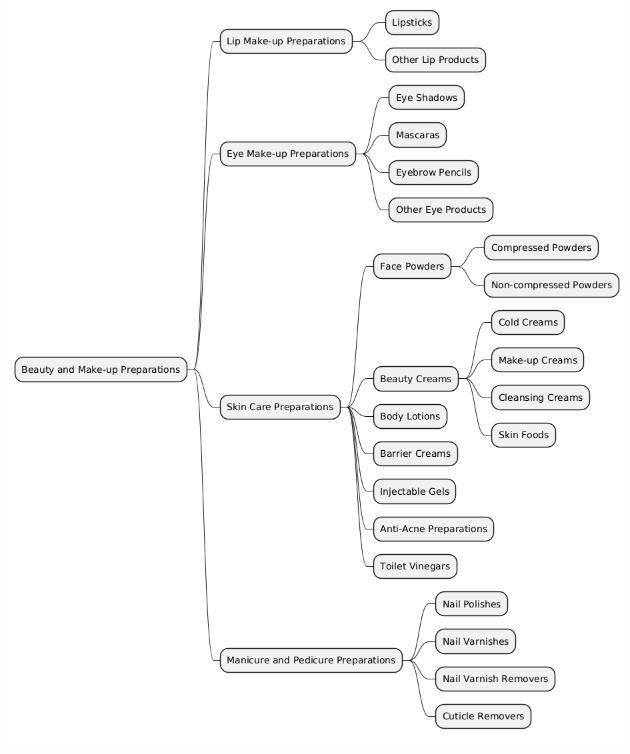